In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import collections
from collections import Counter
import pandas as pd
import codecs
import re
import os.path
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import sys


sys.path.append('python_files')
import utils

C:\Users\Kadem\AppData\Local\Temp\ipykernel_31648\3123791923.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Analyse des données

In [2]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = utils.load_pres(fname)

In [3]:
# Calcul du nombre de textes, de labels uniques et des labels uniques
num_texts = len(alltxts)
num_labels = len(set(alllabs))
unique_labels = list(set(alllabs))

# Calcul du nombre d'occurrences pour chaque label
label_counts = {label: alllabs.count(label) for label in unique_labels}

# Calcul des pourcentages par rapport aux labels
total_labels = len(alllabs)
label_percentages = {label: count / total_labels * 100 for label, count in label_counts.items()}

In [4]:
# Affichage des statistiques et des pourcentages
print("Nombre de textes :", num_texts)
print("Nombre de labels uniques :", num_labels)
print("Labels uniques :", unique_labels)
print("Occurrences des labels :", label_counts)

Nombre de textes : 57413
Nombre de labels uniques : 2
Labels uniques : [1, -1]
Occurrences des labels : {1: 49890, -1: 7523}


In [5]:
print("\nPourcentages par rapport aux labels :")
for label, percentage in label_percentages.items():
    if(label == -1):
        pres = 'François Mitterrand'
    else:
        pres = 'Jacques Chirac'
    print(f"{pres} ( label = ", label,"): {:.2f}%".format(percentage))


Pourcentages par rapport aux labels :
Jacques Chirac ( label =  1 ): 86.90%
François Mitterrand ( label =  -1 ): 13.10%


In [6]:
import pandas as pd

# Create a DataFrame from the texts and labels
df = pd.DataFrame({"Text": alltxts, "Label": alllabs})

df.groupby('Label').describe()

Text                                        
       count unique                         top freq
Label                                               
-1      7523   7522   La liste serait longue.\n    2
 1     49890  48977     Mesdames, Messieurs, \n   56

In [7]:
# Filter the DataFrame for Jacques Chirac (label = 1)
jacques_chirac_texts = df.loc[df["Label"] == 1, "Text"]

# Filter the DataFrame for François Mitterrand (label = -1)
francois_mitterrand_texts = df.loc[df["Label"] == -1, "Text"]

# Statistics for Jacques Chirac
jacques_chirac_stats = jacques_chirac_texts.describe()

# Statistics for François Mitterrand
francois_mitterrand_stats = francois_mitterrand_texts.describe()

In [8]:
# Print the statistics
print("Statistics for Jacques Chirac:")
print(jacques_chirac_stats)

Statistics for Jacques Chirac:
count                        49890
unique                       48977
top        Mesdames, Messieurs, \n
freq                            56
Name: Text, dtype: object


In [9]:
print("\nStatistics for François Mitterrand:")
print(francois_mitterrand_stats)


Statistics for François Mitterrand:
count                           7523
unique                          7522
top        La liste serait longue.\n
freq                               2
Name: Text, dtype: object


### Nombre de textes par label

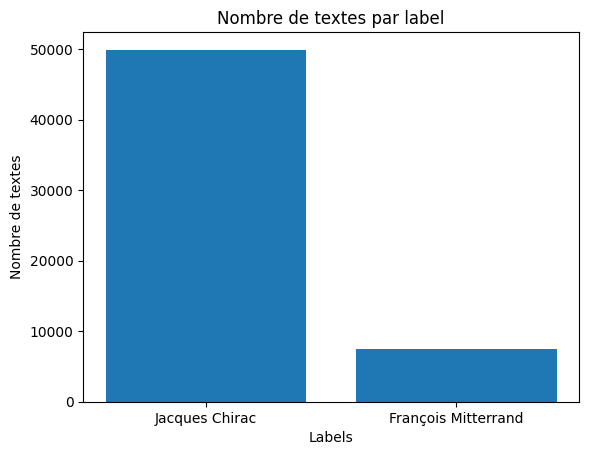

In [10]:
labels_names = ["Jacques Chirac", "François Mitterrand"]
plt.bar(labels_names, label_counts.values())
plt.xlabel("Labels")
plt.ylabel("Nombre de textes")
plt.title("Nombre de textes par label")
plt.show()

### Pourcentages par rapport aux labels

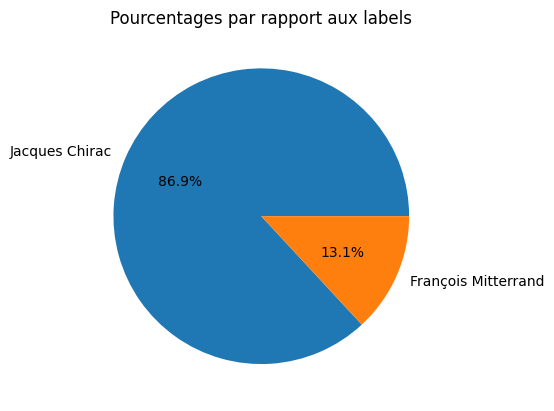

In [11]:
labels = ["Jacques Chirac", "François Mitterrand"]
percentages = [label_percentages[1], label_percentages[-1]]

plt.pie(percentages, labels=labels_names, autopct='%1.1f%%')
plt.title("Pourcentages par rapport aux labels")
plt.show()

### Longueur des phrases par président

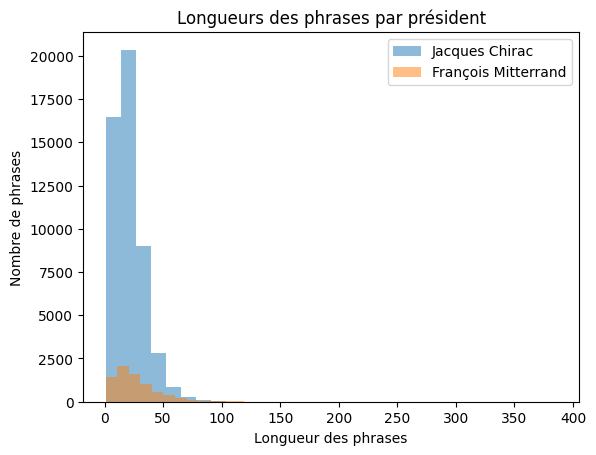

In [12]:
chirac_sentences = [sentence.strip() for text, label in zip(alltxts, alllabs) if label == 1 for sentence in text.split("\n") if sentence.strip()]
mitterrand_sentences = [sentence.strip() for text, label in zip(alltxts, alllabs) if label == -1 for sentence in text.split("\n") if sentence.strip()]

chirac_sentence_lengths = [len(sentence.split()) for sentence in chirac_sentences]
mitterrand_sentence_lengths = [len(sentence.split()) for sentence in mitterrand_sentences]

plt.hist(chirac_sentence_lengths, bins=30, alpha=0.5, label='Jacques Chirac')
plt.hist(mitterrand_sentence_lengths, bins=30, alpha=0.5, label='François Mitterrand')
plt.xlabel('Longueur des phrases')
plt.ylabel('Nombre de phrases')
plt.title('Longueurs des phrases par président')
plt.legend()
plt.show()

# Prétraitements des données

Le prétraitement des textes inclue  

- la suppression de la ponctuation
- la mise en minuscule
- la suppression des stop words
- la lemmatisation (conversion des mots en leur forme de base)

In [13]:
preprocessed_texts = [utils.preprocess(text, lemma=True) for text in alltxts]

In [14]:
# Création d'un tableau comparatif
df = pd.DataFrame({'Texte original': alltxts[:5], 'Texte prétraité': preprocessed_texts[:5]})

# Affichage du tableau
print(df)

                                      Texte original  \
0   Quand je dis chers amis, il ne s'agit pas là ...   
1   D'abord merci de cet exceptionnel accueil que...   
2   C'est toujours très émouvant de venir en Afri...   
3   Aucun citoyen français ne peut être indiffére...   
4   Le Congo, que naguère le <nom> qualifia de "r...   

                                     Texte prétraité  
0    quand je dire cher ami il ne sagit pas le du...  
1    dabord merci de ce exceptionnel accueil que ...  
2    cest toujours tre emouver de venir en afriqu...  
3    aucun citoyen francai ne pouvoir etre indiff...  
4    le congo que naguere le nom qualifier de ref...  


# Extraction du vocabulaire

### Taille du vocabulaire

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialisation du CountVectorizer pour le vocabulaire initial
vectorizer_initial = CountVectorizer()
X_initial = vectorizer_initial.fit_transform(alltxts)
initial_vocab_size = len(vectorizer_initial.vocabulary_)

# Initialisation du CountVectorizer pour le vocabulaire prétraité
vectorizer_preprocessed = CountVectorizer()
X_preprocessed = vectorizer_preprocessed.fit_transform(preprocessed_texts)
preprocessed_vocab_size = len(vectorizer_preprocessed.vocabulary_)

# Affichage des résultats
print("Taille du vocabulaire initial :", initial_vocab_size)
print("Taille du vocabulaire prétraité :", preprocessed_vocab_size)

Taille du vocabulaire initial : 28524
Taille du vocabulaire prétraité : 25377


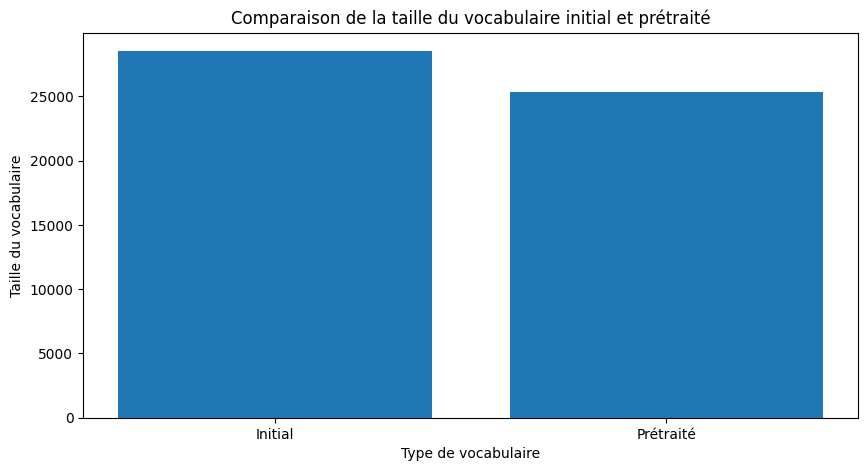

In [16]:
# Plot des deux vocabulaires
plt.figure(figsize=(10, 5))
plt.bar(["Initial", "Prétraité"], [initial_vocab_size, preprocessed_vocab_size])
plt.xlabel("Type de vocabulaire")
plt.ylabel("Taille du vocabulaire")
plt.title("Comparaison de la taille du vocabulaire initial et prétraité")
plt.show()

### Word clouds : Mots du vocabulaire 

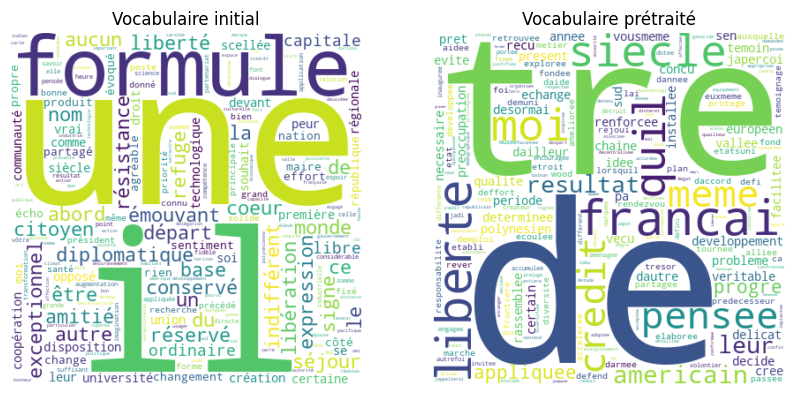

In [17]:
# Création du nuage de mots pour le vocabulaire initial
wordcloud_initial = WordCloud(background_color="white", width=400, height=400).generate(' '.join(vectorizer_initial.vocabulary_.keys()))

# Création du nuage de mots pour le vocabulaire prétraité
wordcloud_preprocessed = WordCloud(background_color="white", width=400, height=400).generate(' '.join(vectorizer_preprocessed.vocabulary_.keys()))

# Affichage des mots du vocabulaire initial et prétraité côte à côte
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Premier sous-graphique : vocabulaire initial
axes[0].imshow(wordcloud_initial, interpolation='bilinear')
axes[0].set_title("Vocabulaire initial")
axes[0].axis('off')

# Deuxième sous-graphique : vocabulaire prétraité
axes[1].imshow(wordcloud_preprocessed, interpolation='bilinear')
axes[1].set_title("Vocabulaire prétraité")
axes[1].axis('off')

# Ajustement de l'espacement entre les sous-graphiques
plt.subplots_adjust(wspace=0.2)

# Affichage de la figure
plt.show()

### 10 mots les plus utilisés pour chaque président


In [18]:
# nltk.download('punkt')

chirac_texts = [text for text, label in zip(preprocessed_texts, alllabs) if label == 1]
mitterrand_texts = [text for text, label in zip(preprocessed_texts, alllabs) if label == -1]

chirac_words = nltk.word_tokenize(" ".join(chirac_texts))
mitterrand_words = nltk.word_tokenize(" ".join(mitterrand_texts))

chirac_words = [word.lower() for word in chirac_words]
mitterrand_words = [word.lower() for word in mitterrand_words]

chirac_word_counts = Counter(chirac_words)
mitterrand_word_counts = Counter(mitterrand_words)

top_10_chirac_words = chirac_word_counts.most_common(10)
top_10_mitterrand_words = mitterrand_word_counts.most_common(10)

In [19]:
print("Les 10 mots les plus utilisés par Jacques Chirac :")
for word, count in top_10_chirac_words:
    print(word, ":", count)

print("\nLes 10 mots les plus utilisés par François Mitterrand :")
for word, count in top_10_mitterrand_words:
    print(word, ":", count)

Les 10 mots les plus utilisés par Jacques Chirac :
le : 81535
de : 81441
avoir : 35066
et : 32457
un : 22282
être : 14448
ce : 13303
en : 12986
qui : 12650
que : 12579

Les 10 mots les plus utilisés par François Mitterrand :
le : 14655
de : 13767
avoir : 7265
et : 4786
un : 4070
que : 3726
ce : 3270
qui : 2984
être : 2962
en : 2297


### Word cloud des mots les plus fréquents par président

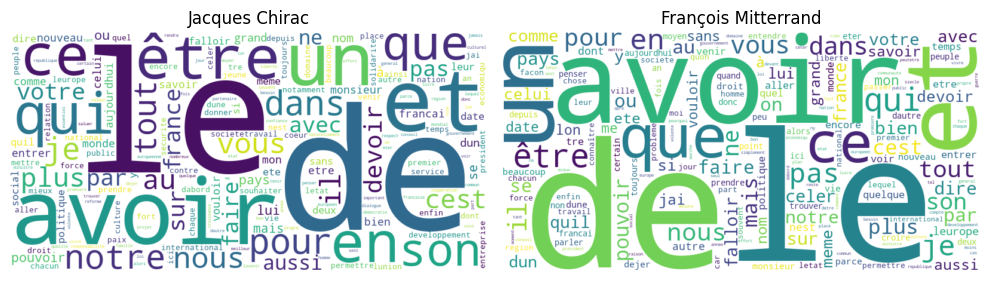

In [20]:
chirac_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(chirac_word_counts)
mitterrand_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(mitterrand_word_counts)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(chirac_wordcloud, interpolation='bilinear')
plt.title('Jacques Chirac')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mitterrand_wordcloud, interpolation='bilinear')
plt.title('François Mitterrand')
plt.axis('off')

plt.tight_layout()
plt.show()

### Les mots communs les plus fréquents

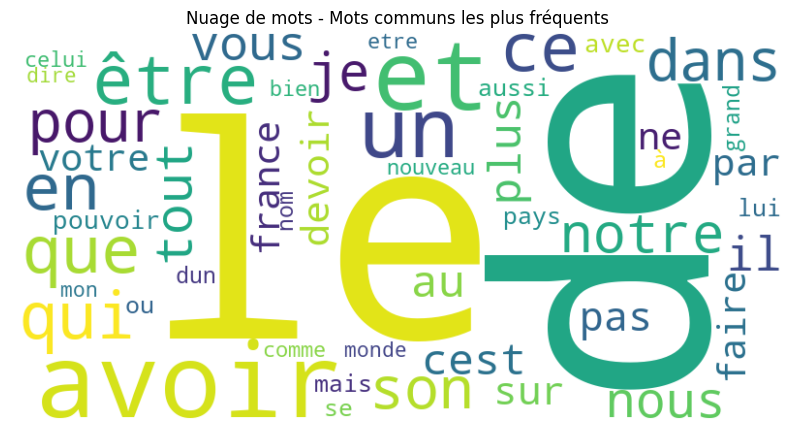

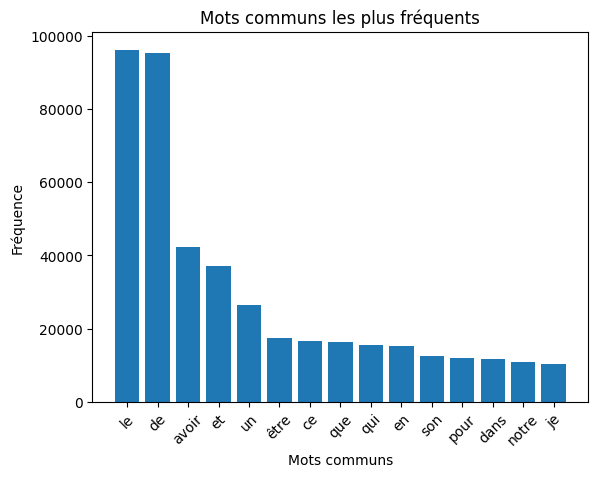

In [21]:
common_words = set(chirac_word_counts.keys()).intersection(set(mitterrand_word_counts.keys()))
common_word_counts = {word: chirac_word_counts[word] + mitterrand_word_counts[word] for word in common_words}
common_word_counts = dict(sorted(common_word_counts.items(), key=lambda x: x[1], reverse=True)[:50])

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_word_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots - Mots communs les plus fréquents')
plt.show()

# Tracé des mots communs les plus fréquents
common_word_counts = dict(sorted(common_word_counts.items(), key=lambda x: x[1], reverse=True)[:15])
plt.bar(common_word_counts.keys(), common_word_counts.values())
plt.xlabel('Mots communs')
plt.ylabel('Fréquence')
plt.title('Mots communs les plus fréquents')
plt.xticks(rotation=45)
plt.show()

### Word cloud : odds ratio

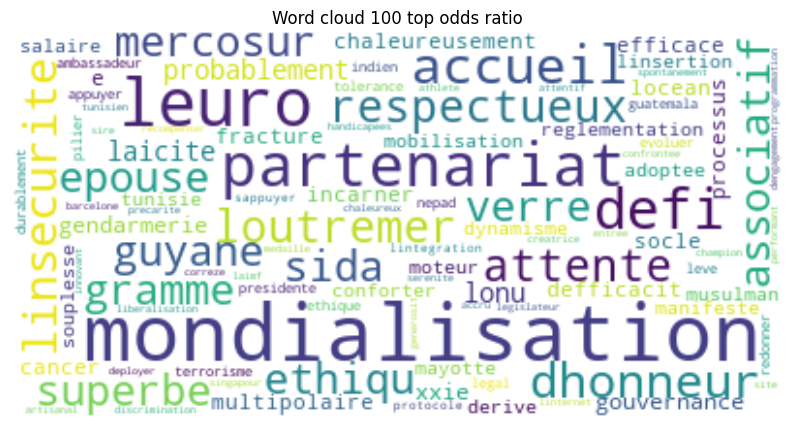

In [22]:
class1_words = ' '.join(chirac_texts).split()
class2_words = ' '.join(mitterrand_texts).split()

class1_counter = Counter(class1_words)
class2_counter = Counter(class2_words)

odds_ratios = {}

for word, freq_class1 in class1_counter.items():
    freq_class2 = class2_counter[word]
    total_words_class1 = sum(class1_counter.values())
    total_words_class2 = sum(class2_counter.values())
    odds_ratios[word] = ((freq_class1 + 1) / (total_words_class1 + len(class1_counter))) / ((freq_class2 + 1) / (total_words_class2 + len(class2_counter)))

sorted_odds_ratios = sorted(odds_ratios.items(), key=lambda x: x[1], reverse=True)
top_100_odds_ratios = dict(sorted_odds_ratios[:100])

wc = WordCloud(background_color='white').generate_from_frequencies(top_100_odds_ratios)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 top odds ratio')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Loi de Zipf

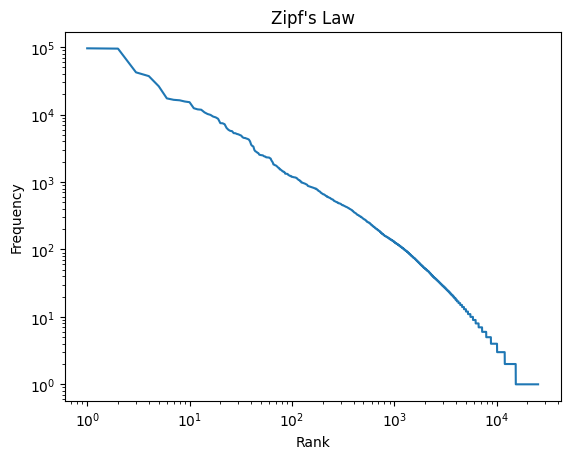

In [23]:
corpus_clean = ' '.join(preprocessed_texts).lower()
word_counts = Counter(corpus_clean.split())
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
word_freqs = [word_counts[w] for w in sorted_words]
ranks = range(1, len(sorted_words) + 1)

plt.title('Zipf\'s Law')
plt.plot(ranks, word_freqs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

### Bigrammes les plus fréquents

In [24]:
vectorizer = CountVectorizer(ngram_range=(2,2))
X = vectorizer.fit_transform(preprocessed_texts)

bigram_frequencies = np.array(X.sum(axis=0))[0]
bigram_frequencies_sorted = (-bigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()
sorted_features = [features[i] for i in bigram_frequencies_sorted[:100]]

tmp_df = pd.DataFrame()
bigrams = sorted_features
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = bigrams[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,de le,de son,le plus,et avoir,être un,avoir faire,le paix,par un,parce que,de droit
1,et de,sur le,que nous,dans un,le president,ce que,je le,que ce,le premier,le securite
2,dans le,pour le,nous avoir,dans ce,celui de,cest le,tout avoir,nous être,le pays,respect de
3,avoir le,avoir un,avec le,que vous,avoir tout,de monde,le vie,ne être,mettre en,tout son
4,et le,par le,de tout,devoir etre,et qui,le monde,avoir notre,le francai,et son,dans son
5,le france,qui être,vous avoir,je vouloir,ce qui,ne pouvoir,de nouveau,ou le,contre le,de leurope
6,de notre,qui avoir,être le,celui qui,nest pas,entrer le,de plus,le grand,je souhaiter,dans notre
7,que le,monsieur le,avoir ete,avoir son,cest un,notre pays,mais aussi,lui être,en date,que lon
8,tout le,il falloir,avoir ce,et je,nous devoir,je être,ce être,le republique,qui se,pour que
9,de ce,il avoir,de votre,il être,que je,et un,le meme,plus de,je vous,je penser


### Trigrammes les plus fréquents

In [25]:
vectorizer = CountVectorizer(ngram_range=(3,3))
X = vectorizer.fit_transform(preprocessed_texts)

trigram_frequencies = np.array(X.sum(axis=0))[0]
trigram_frequencies_sorted = (-trigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()
sorted_features = [features[i] for i in trigram_frequencies_sorted[:100]]
tmp_df = pd.DataFrame()
bigrams = sorted_features
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = bigrams[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,de le france,avoir tout le,avoir le fois,qui avoir ete,de droit de,tout celui qui,madame et monsieur,pour que le,qui devoir etre,je vouloir vous
1,monsieur le president,le respect de,notre deux pays,qui être le,et avoir le,sur le plan,il avoir un,mesdame et monsieur,le sens de,et dans le
2,et de le,et le france,au sein de,au cours de,ne pouvoir pas,le lutte contre,avoir ce que,mettre en place,de le communaute,de le securite
3,de tout le,que le france,de notre pays,de le paix,au nom de,dans tout le,le cadre de,le droit de,le premier ministre,avoir le france
4,dans le monde,dans le domaine,que nous avoir,dans le cadre,droit de lhomme,de le democratie,lutte contre le,de le nation,president de le,le communaute international
5,de le republique,ce nest pas,tout avoir lheur,le president de,le mise en,ce qui être,le force de,ne devoir pas,de le societe,avoir loccasion de
6,ne être pas,de le vie,il ny avoir,au coeur de,je souhaiter que,le moyen de,entrer notre deux,en meme temps,il falloir que,ce être le
7,au service de,le france être,le france et,je être heureux,celui de le,de celui qui,le developpement de,en faveur de,plus que jamais,que nous devoir
8,que vous avoir,de plus en,et de son,monsieur le maire,le qualite de,celui qui avoir,je tenir avoir,et monsieur le,être heureux de,dans le respect
9,le france avoir,plus en plus,ny avoir pas,le domaine de,tout avoir faire,mettre en oeuvre,je savoir que,dans ce domaine,tout le francai,de votre pays


## Stops words 

### Liste des stop words français

In [26]:
tmp_sw = stopwords.words('french') + ['']*3
tmp_df = pd.DataFrame()
for i in range(1, 17):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = tmp_sw[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100,101 - 110,111 - 120,121 - 130,131 - 140,141 - 150,151 - 160
0,au,en,lui,notre,sa,tu,à,étant,serai,seraient,furent,fussiez,ai,auront,avaient,aient
1,aux,et,ma,nous,se,un,m,étante,seras,étais,sois,fussent,as,aurais,eut,eusse
2,avec,eux,mais,on,ses,une,n,étants,sera,était,soit,ayant,avons,aurait,eûmes,eusses
3,ce,il,me,ou,son,vos,s,étantes,serons,étions,soyons,ayante,avez,aurions,eûtes,eût
4,ces,ils,même,par,sur,votre,t,suis,serez,étiez,soyez,ayantes,ont,auriez,eurent,eussions
5,dans,je,mes,pas,ta,vous,y,es,seront,étaient,soient,ayants,aurai,auraient,aie,eussiez
6,de,la,moi,pour,te,c,été,est,serais,fus,fusse,eu,auras,avais,aies,eussent
7,des,le,mon,qu,tes,d,étée,sommes,serait,fut,fusses,eue,aura,avait,ait,
8,du,les,ne,que,toi,j,étées,êtes,serions,fûmes,fût,eues,aurons,avions,ayons,
9,elle,leur,nos,qui,ton,l,étés,sont,seriez,fûtes,fussions,eus,aurez,aviez,ayez,


### Taille du vocabulaire SANS STOP WORDS

In [27]:
from nltk.corpus import stopwords

# Affichage avant la suppression des STOP WORDS
print("Taille du vocabulaire initial :", initial_vocab_size)
print("Taille du vocabulaire prétraité :", preprocessed_vocab_size)

# Charger les stopwords en français depuis NLTK
stop_words = stopwords.words('french')

# Suppression des stop words du texte initial
texts_no_stopwords = [' '.join([word for word in text.split(' ') if word not in stop_words]) for text in alltxts]

# Prétraitment du texte sans stop words
preprocessed_texts_no_stopwords = [utils.preprocess(text, lemma=True) for text in texts_no_stopwords]

# Initialisation du CountVectorizer pour le vocabulaire initial
vectorizer_initial = CountVectorizer(stop_words=stop_words)
X_initial = vectorizer_initial.fit_transform(texts_no_stopwords)
initial_vocab_size = len(vectorizer_initial.vocabulary_)

# Initialisation du CountVectorizer pour le vocabulaire prétraité avec suppression des stopwords en français
vectorizer_preprocessed = CountVectorizer(stop_words=stop_words)
X_preprocessed = vectorizer_preprocessed.fit_transform(preprocessed_texts_no_stopwords)
preprocessed_vocab_size = len(vectorizer_preprocessed.vocabulary_)

# Affichage des résultats
print("Taille du vocabulaire SANS STOP WORDS initial :", initial_vocab_size)
print("Taille du vocabulaire SANS STOP WORDS prétraité :", preprocessed_vocab_size)

Taille du vocabulaire initial : 28524
Taille du vocabulaire prétraité : 25377
Taille du vocabulaire SANS STOP WORDS initial : 28400
Taille du vocabulaire SANS STOP WORDS prétraité : 26949


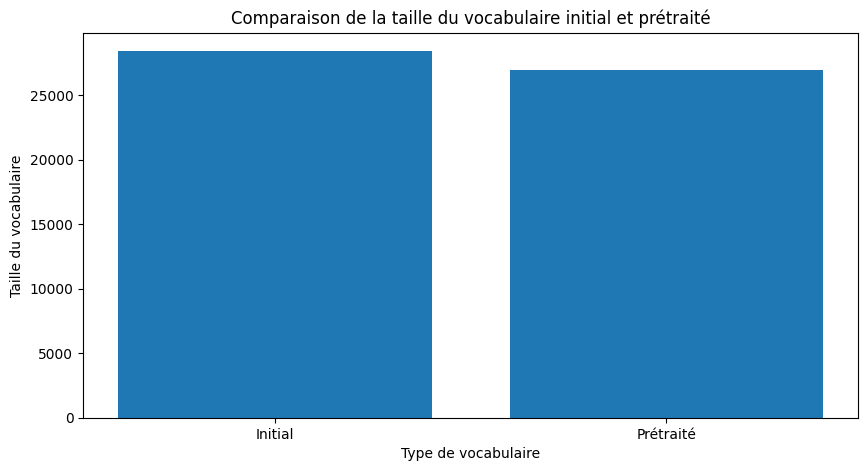

In [28]:
# Plot des deux vocabulaires
plt.figure(figsize=(10, 5))
plt.bar(["Initial", "Prétraité"], [initial_vocab_size, preprocessed_vocab_size])
plt.xlabel("Type de vocabulaire")
plt.ylabel("Taille du vocabulaire")
plt.title("Comparaison de la taille du vocabulaire initial et prétraité")
plt.show()

### Word clouds : Mots du vocabulaire SANS STOP WORDS

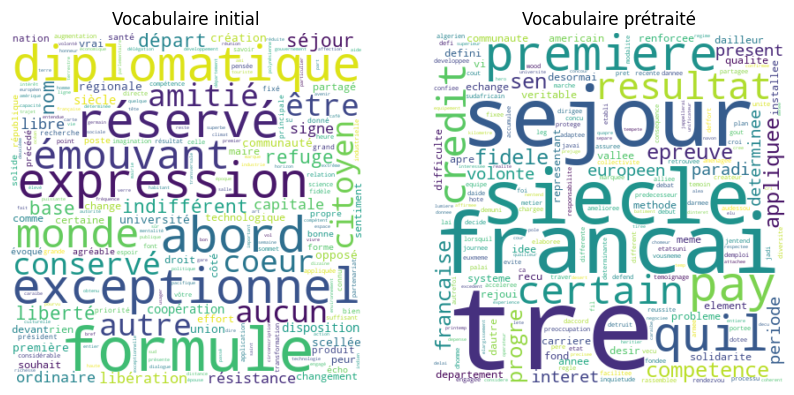

In [29]:
# Création du nuage de mots pour le vocabulaire initial
wordcloud_initial = WordCloud(background_color="white", width=400, height=400).generate(' '.join(vectorizer_initial.vocabulary_.keys()))

# Création du nuage de mots pour le vocabulaire prétraité
wordcloud_preprocessed = WordCloud(background_color="white", width=400, height=400).generate(' '.join(vectorizer_preprocessed.vocabulary_.keys()))

# Affichage des mots du vocabulaire initial et prétraité côte à côte
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Premier sous-graphique : vocabulaire initial
axes[0].imshow(wordcloud_initial, interpolation='bilinear')
axes[0].set_title("Vocabulaire initial")
axes[0].axis('off')

# Deuxième sous-graphique : vocabulaire prétraité
axes[1].imshow(wordcloud_preprocessed, interpolation='bilinear')
axes[1].set_title("Vocabulaire prétraité")
axes[1].axis('off')

# Ajustement de l'espacement entre les sous-graphiques
plt.subplots_adjust(wspace=0.2)

# Affichage de la figure
plt.show()

### 10 mots les plus utilisés pour chaque président SANS STOP WORDS


In [30]:
# nltk.download('punkt')

chirac_texts = [text for text, label in zip(preprocessed_texts_no_stopwords, alllabs) if label == 1]
mitterrand_texts = [text for text, label in zip(preprocessed_texts_no_stopwords, alllabs) if label == -1]

chirac_words = nltk.word_tokenize(" ".join(chirac_texts))
mitterrand_words = nltk.word_tokenize(" ".join(mitterrand_texts))

chirac_words = [word.lower() for word in chirac_words if word.isalpha() and word.lower() not in stopwords.words('french')]
mitterrand_words = [word.lower() for word in mitterrand_words if word.isalpha() and word.lower() not in stopwords.words('french')]

chirac_word_counts = Counter(chirac_words)
mitterrand_word_counts = Counter(mitterrand_words)

top_10_chirac_words = chirac_word_counts.most_common(10)
top_10_mitterrand_words = mitterrand_word_counts.most_common(10)

In [31]:
print("Les 10 mots les plus utilisés par Jacques Chirac :")
for word, count in top_10_chirac_words:
    print(word, ":", count)

print("\nLes 10 mots les plus utilisés par François Mitterrand :")
for word, count in top_10_mitterrand_words:
    print(word, ":", count)

Les 10 mots les plus utilisés par Jacques Chirac :
tout : 8362
avoir : 6555
plus : 6267
cest : 6042
devoir : 4987
france : 4369
faire : 4003
aussi : 3883
pouvoir : 3719
nom : 3120

Les 10 mots les plus utilisés par François Mitterrand :
tout : 1551
avoir : 1519
plus : 1175
cest : 1165
pouvoir : 1095
faire : 912
bien : 829
dire : 814
france : 728
celer : 716


### Word cloud des mots les plus fréquents par président SANS STOP WORDS

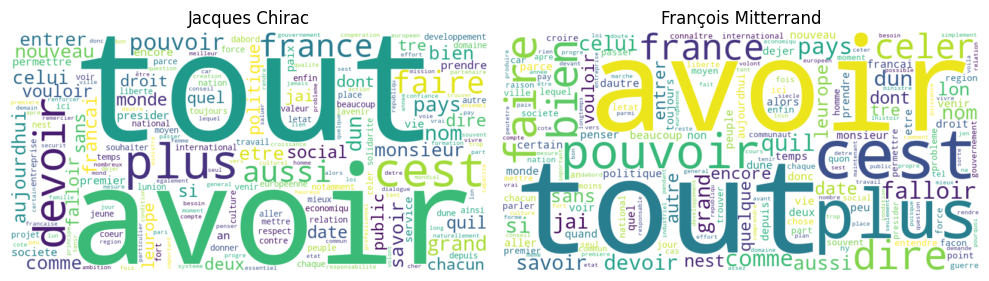

In [32]:
chirac_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(chirac_word_counts)
mitterrand_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(mitterrand_word_counts)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(chirac_wordcloud, interpolation='bilinear')
plt.title('Jacques Chirac')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mitterrand_wordcloud, interpolation='bilinear')
plt.title('François Mitterrand')
plt.axis('off')

plt.tight_layout()
plt.show()

### Les mots communs les plus fréquents SANS STOP WORDS

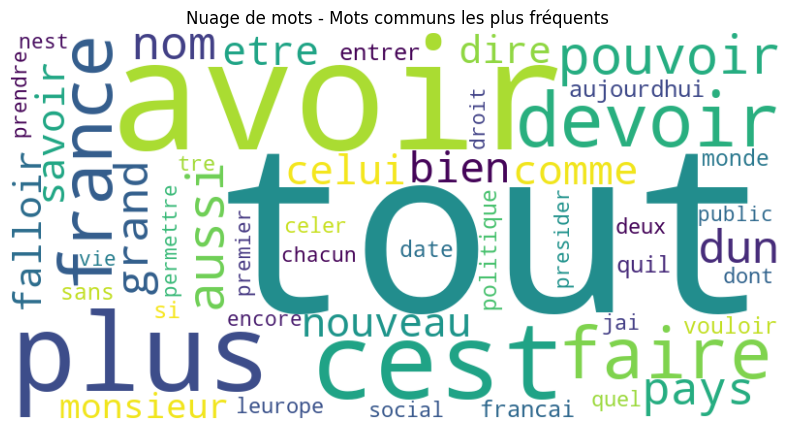

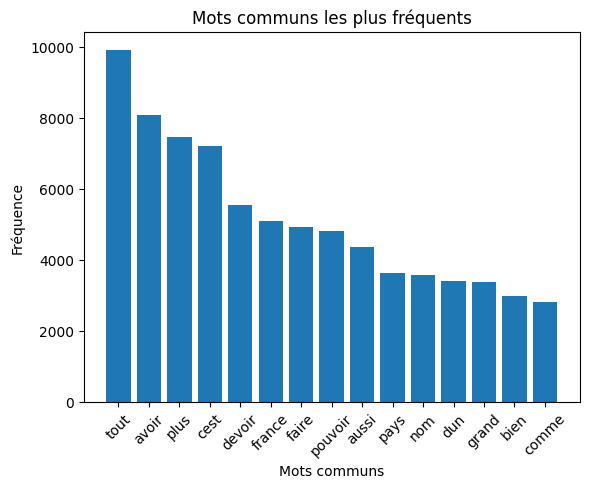

In [33]:
common_words = set(chirac_word_counts.keys()).intersection(set(mitterrand_word_counts.keys()))
common_word_counts = {word: chirac_word_counts[word] + mitterrand_word_counts[word] for word in common_words}
common_word_counts = dict(sorted(common_word_counts.items(), key=lambda x: x[1], reverse=True)[:50])

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_word_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots - Mots communs les plus fréquents')
plt.show()

# Tracé des mots communs les plus fréquents
common_word_counts = dict(sorted(common_word_counts.items(), key=lambda x: x[1], reverse=True)[:15])
plt.bar(common_word_counts.keys(), common_word_counts.values())
plt.xlabel('Mots communs')
plt.ylabel('Fréquence')
plt.title('Mots communs les plus fréquents')
plt.xticks(rotation=45)
plt.show()

### Bigrammes les plus fréquents SANS STOP WORDS

In [34]:
from nltk.tokenize import word_tokenize

# Tokenization et filtrage des mots
filtered_texts = []
for text in preprocessed_texts_no_stopwords:
    tokens = word_tokenize(text)
    filtered_tokens = [token.lower() for token in tokens if token.isalpha()]
    filtered_texts.append(' '.join(filtered_tokens))

# Extraction des bigrammes les plus fréquents
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords.words('french'))
X = vectorizer.fit_transform(filtered_texts)

bigram_frequencies = np.array(X.sum(axis=0))[0]
bigram_frequencies_sorted = (-bigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()
sorted_features = [features[i] for i in bigram_frequencies_sorted[:100]]

tmp_df = pd.DataFrame()
bigrams = sorted_features
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = bigrams[((i - 1) * 10) : i * 10]

# Affichage des bigrammes les plus fréquents
print(tmp_df)

              1 - 10           11 - 20           21 - 30           31 - 40  \
0        devoir etre      quil falloir    service public         tout fait   
1  monsieur presider          ny avoir    monsieur maire    rendre hommage   
2       pouvoir etre      france avoir  premier ministre      mettre place   
3  lunion europeenne  mesdame monsieur       droit lhomm        sans doute   
4         cest aussi        tout lheur       avoir faire        chef detat   
5         plus grand        tout celui        quil avoir     chacun dentre   
6          deux pays   madame monsieur     bien entendre         plus fort   
7          plus plus           nom nom     mettre oeuvre  lunion europeenn   
8          cest vrai      lutte contre        tout celer          cher ami   
9      cest pourquoi       entrer deux      vouloir dire       plus jamais   

          41 - 50           51 - 60          61 - 70                  71 - 80  \
0       nom avoir         plus loin    pouvoir faire        

### Trigrammes les plus fréquents SANS STOP WORDS

In [35]:
# Tokenization et filtrage des mots
filtered_texts = []
for text in preprocessed_texts_no_stopwords:
    tokens = word_tokenize(text)
    filtered_tokens = [token.lower() for token in tokens if token.isalpha()]
    filtered_texts.append(' '.join(filtered_tokens))

# Extraction des trigrammes les plus fréquents
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words=stopwords.words('french'))
X_trigram = trigram_vectorizer.fit_transform(filtered_texts)

trigram_frequencies = np.array(X_trigram.sum(axis=0))[0]
trigram_frequencies_sorted = (-trigram_frequencies).argsort()

trigram_features = trigram_vectorizer.get_feature_names_out()
sorted_trigram_features = [trigram_features[i] for i in trigram_frequencies_sorted[:100]]

tmp_df_trigram = pd.DataFrame()
trigrams = sorted_trigram_features
for i in range(1, 11):
    tmp_df_trigram[f'{1 + (i - 1) * 10} - {i * 10}'] = trigrams[((i - 1) * 10) : i * 10]

# Affichage des trigrammes les plus fréquents
print(tmp_df_trigram)

                      1 - 10                     11 - 20  \
0           entrer deux pays   presider mesdame monsieur   
1            tout celle tout   monsieur presider mesdame   
2           celle tout celui           plus grand nombre   
3    chef detat gouvernement               quil ny avoir   
4       chacun chacun dentre             dire tout lheur   
5           sans aucun doute  ministre affaire etrangere   
6  monsieur premier ministre              si lon vouloir   
7                nom nom nom            pays plus pauvre   
8            aller plus loin               tout long vie   
9          cest pourquoi jai              jour apre jour   

                    21 - 30                         31 - 40  \
0        plus plus nombreux         lutte contre lexclusion   
1   lunion europeenne avoir  lorganisation mondial commerce   
2      mieux prendre compte                 celer aller soi   
3          tout devoir etre             vouloir tout dabord   
4        cest raison leq